In [1]:
from pydantic import BaseModel, Field
from typing import Literal
from dotenv import load_dotenv, find_dotenv
from IPython.display import Image, display

from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


In [2]:
load_dotenv(find_dotenv())

True

In [3]:
gpt = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
class Q1_SubquestionAnswers(BaseModel):
    q1: Literal[True, False, None] = Field(None, description="Is the system a machine-based system?")
    q2: Literal[True, False, None] = Field(None, description="May the system exhibit adaptiveness after deployment?")
    q3: Literal[True, False, None] = Field(None, description="Is it capable of inferring how to generate outputs?")
    q4: Literal[True, False, None] = Field(None, description="Can the system outputs influence environments?")
    q5: Literal[True, False, None] = Field(None, description="Is the system designed with varying autonomy levels?")

    def all(self):
        return all([self.q1, self.q2, self.q3, self.q4, self.q5])
    
    def all_not(self):
        return all([not self.q1, not self.q2, not self.q3, not self.q4, not self.q5])
    
    def __iter__(self):
        for attr in ['q1', 'q2', 'q3', 'q4', 'q5']:
            yield getattr(self, attr)

In [ ]:
prompt = """
Analyze the user's response to determine if it contains a clear, direct answer to each of the following questions. Only respond with:
- "True" if the response explicitly and directly confirms the answer to the question without needing assumptions.
- "False" if the response explicitly denies the answer.
- "None" if there is no clear and explicit information in the response to answer the question.

Questions:
1. Is the system a machine-based system?
2. May the system exhibit adaptiveness after deployment?
3. Is it capable, for explicit or implicit objectives, of inferring, from the input it receives, how to generate outputs such as predictions, content, recommendations, or decisions?
4. Can the system outputs influence physical or virtual environments?
5. Is the system designed to operate with varying levels of autonomy?

Be cautious to only answer "True" or "False" where there is explicit, unambiguous information in the user's response, and use "None" if the answer is not directly clear.

Question: What type of system are you developing?
User's response: {response}
""".strip()

prompt_template = PromptTemplate(input_variables=["response"], template=prompt)
llm_q1 = gpt.with_structured_output(Q1_SubquestionAnswers)
q1_chain = prompt_template | llm_q1

In [70]:
class subquestion_explanations(BaseModel):
    q1: str = Field(None, description="Is the system a machine-based system?")
    q2: str = Field(None, description="May the system exhibit adaptiveness after deployment?")
    q3: str = Field(None, description="Is it capable of inferring how to generate outputs?")
    q4: str = Field(None, description="Can the system outputs influence environments?")
    q5: str = Field(None, description="Is the system designed with varying autonomy levels?")

    def all(self):
        return all([self.q1, self.q2, self.q3, self.q4, self.q5])
    
    def all_not(self):
        return all([not self.q1, not self.q2, not self.q3, not self.q4, not self.q5])
    
    def __iter__(self):
        for attr in ['q1', 'q2', 'q3', 'q4', 'q5']:
            yield getattr(self, attr)
    
    def combine_answers(self):
        combined = "\n".join([f"{getattr(self, attr)}" for attr in ['q1', 'q2', 'q3', 'q4', 'q5']])
        return combined

In [71]:
def generate_agent_explanations(history, explanation_chain):
    # Generate the analysis
    analysis = analyze_history_responses(history, explanation_chain)
    return analysis.combine_answers()
# Function to analyze the history and generate explanations
def analyze_history_responses(history, explanation_chain):
    # Invoke the explanation chain with the formatted history
    analysis = explanation_chain.invoke({"history": history})
    return analysis

# Define the explanation prompt
explanation_prompt = """
Given the user's history of responses, analyze whether all the answers to the following questions are "True" If all answers are True provide a deatiled explanation for each response to justify why it was marked as "True"

History of responses:
{history}

Questions:
1. Is the system a machine-based system?
2. May the system exhibit adaptiveness after deployment?
3. Is it capable, for explicit or implicit objectives, of inferring, from the input it receives, how to generate outputs such as predictions, content, recommendations, or decisions?
4. Can the system outputs influence physical or virtual environments?
5. Is the system designed to operate with varying levels of autonomy?

Output:
- For each question: "[Explanation]"

Be cautious to only provide explanations where there is explicit, unambiguous information in the user's responses.
""".strip()
# Example usage
history = """ It is a machine-based system that uses AI algorithms. The system adapts based on new data after deployment. It generates predictions and recommendations based on input data. Outputs are used to adjust virtual interfaces. It operates with semi-autonomous features, depending on the configuration. """

# Define the PromptTemplate
explanation_prompt_template = PromptTemplate(input_variables=["history"], template=explanation_prompt)

# Assuming `gpt.with_structured_output` is a valid LLM wrapper and `subquestion_explanations` is defined:
llm_explanation = gpt.with_structured_output(subquestion_explanations)
explanation_chain = explanation_prompt_template | llm_explanation

In [72]:
class GraphState(MessagesState):
    subquestion_answers: Q1_SubquestionAnswers
    explanations: str

In [73]:
# Define the function to process the user's response
def process_response(state: GraphState) -> GraphState:
    messages = state["messages"]
    # user response is every even number message
    user_response = ""
    for i in range(0, len(messages), 2):
        user_response += messages[i].content + "\n"
    sub_answers_new = q1_chain.invoke({"response": user_response})
    if "subquestion_answers" in state:
        sub_answers_existing = state["subquestion_answers"]
    else:
        sub_answers_existing = Q1_SubquestionAnswers()
    for attr in ['q1', 'q2', 'q3', 'q4', 'q5']:
        if not getattr(sub_answers_existing, attr):
            setattr(sub_answers_existing, attr, getattr(sub_answers_new, attr))
    return {"subquestion_answers": sub_answers_existing}  

# Define the function to process the user's response
def generate_explanations(state: GraphState) -> GraphState:
    messages = state["messages"]
    # user response is every even number message
    user_response = ""
    for i in range(0, len(messages), 2):
        user_response += messages[i].content + "\n"
    return {"explanations": generate_agent_explanations(user_response, explanation_chain)}

# Define the function to check if all subquestions are answered
def check_completion(state: GraphState) -> bool:
    answers = state["subquestion_answers"]
    all_not_none = all([answer is not None for answer in answers])
    return all_not_none

# Define the function to inform the user about vague parts
def inform_user(state: GraphState) -> str:
    vague_parts = [
        f"{desc}"
        for desc, answer in zip(
            [
                "Is the system a machine-based system?",
                "May the system exhibit adaptiveness after deployment?",
                "Is it capable of inferring how to generate outputs?",
                "Can the system outputs influence environments?",
                "Is the system designed with varying autonomy levels?",
            ],
            state["subquestion_answers"],
        )
        if answer is None
    ]
    vague_str = "\n".join(vague_parts)
    suggestion = (
        "The following parts of your description are vague or unclear:\n"
        f"{vague_str}\n\n"
        "Please provide more details to clarify these aspects."
    )
    return {"messages": AIMessage(content=suggestion)}

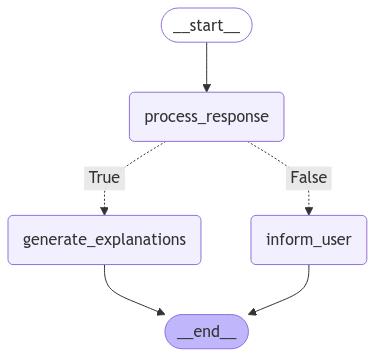

In [74]:
# Initialize the StateGraph
graph_builder = StateGraph(GraphState)

# Add nodes to the graph
graph_builder.add_node("process_response", process_response)
graph_builder.add_node("inform_user", inform_user)
graph_builder.add_node("generate_explanations", generate_explanations)

# Define the edges with conditions
graph_builder.add_edge(START, "process_response")
graph_builder.add_conditional_edges("process_response", check_completion, {True: "generate_explanations", False: "inform_user"})
graph_builder.add_edge("inform_user", END)
graph_builder.add_edge("generate_explanations", END)
# Compile the graph
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [75]:
prompt_input = "I am building a legal chatbot for helping students of law."
config = {"configurable": {"thread_id": 1}}
result = graph.invoke({"messages": [HumanMessage(prompt_input)]}, config=config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

I am building a legal chatbot for helping students of law.


In [76]:
result2 = graph.invoke(
    {
        "messages": [
            HumanMessage(
                "The system adapts and can affect the environment and infers how to generate the output by observing the history. I can configure how autonomous I want it to be."
            )
        ]
    },
    config=config,
)
for m in result2['messages']:
    m.pretty_print()

================================ Human Message =================================

I am building a legal chatbot for helping students of law.
================================ Human Message =================================

The system adapts and can affect the environment and infers how to generate the output by observing the history. I can configure how autonomous I want it to be.


In [77]:
print(result2["explanations"])

The legal chatbot is a software application, which qualifies it as a machine-based system.
The chatbot may improve its responses over time based on user interactions, indicating adaptiveness after deployment.
The chatbot can generate responses to legal queries based on the input it receives, showing it can infer how to generate outputs.
The chatbot's responses can influence users' understanding and decisions in legal contexts, affecting virtual environments.
The chatbot may operate with varying levels of autonomy, such as providing automated responses or requiring human intervention for complex queries.


In [70]:
class Q2_SubquestionAnswers(BaseModel):
    q1: Literal[True, False, None] = Field(None, description="Are you placing your AI system on the market or putting it into service in the European Union?")
    q2: Literal[True, False, None] = Field(None, description="Are you established or are located in a third country, but the output produced by your AI system is used in the European Union?")

In [71]:
prompt = """
Based on the user's response, answer each of the below two questions with True, False, or None based on the information provided. If details are lacking, respond with None.

<Questions>
- Are you placing your AI system on the market or putting it into service in the European Union?
- Are you established or are located in a third country, but the output produced by your AI system is used in the European Union?
</Questions>
<User Response>
{response}
</User Response>
""".strip()

prompt_template = PromptTemplate(input_variables=["response"], template=prompt)
llm_q2 = gpt.with_structured_output(Q2_SubquestionAnswers)
q2_chain = prompt_template | llm_q2

In [72]:
class GraphState_Q2(MessagesState):
    subquestion_answers: Q2_SubquestionAnswers


def process_response_q2(state: GraphState_Q2) -> GraphState_Q2:
    messages = state["messages"]
    # user response is every odd number message
    user_response = ""
    for i in range(1, len(messages), 2):
        user_response += messages[i].content + "\n"
    sub_answers_new = q2_chain.invoke({"response": user_response})
    if "subquestion_answers" in state:
        sub_answers_existing = state["subquestion_answers"]
    else:
        sub_answers_existing = Q2_SubquestionAnswers()
    for attr in ["q1", "q2"]:
        if not getattr(sub_answers_existing, attr):
            setattr(sub_answers_existing, attr, getattr(sub_answers_new, attr))
    return {"subquestion_answers": sub_answers_existing}


def check_completion_q2(state: GraphState_Q2) -> bool:
    answers = state["subquestion_answers"]
    any_not_none = answers.q1 is not None or answers.q2 is not None
    return any_not_none


def inform_user_q2(state: GraphState_Q2) -> str:
    suggestion = "I couldn't understand your response. To help me understand how your AI system is used, could you let me know if it's connected in any way to the European Union—either by being sold, serviced, or having its output used there?"
    return {"messages": AIMessage(content=suggestion)}

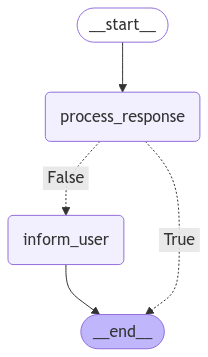

In [73]:
# Initialize the StateGraph
graph_builder_q2 = StateGraph(GraphState_Q2)

# Add nodes to the graph
graph_builder_q2.add_node("process_response", process_response_q2)
graph_builder_q2.add_node("inform_user", inform_user_q2)

# Define the edges with conditions
graph_builder_q2.add_edge(START, "process_response")
graph_builder_q2.add_conditional_edges("process_response", check_completion_q2, {True: END, False: "inform_user"})
graph_builder_q2.add_edge("inform_user", END)

# Compile the graph
memory_q2 = MemorySaver()
graph_q2 = graph_builder_q2.compile(checkpointer=memory_q2)
display(Image(graph_q2.get_graph(xray=True).draw_mermaid_png()))

In [74]:
prompt_input = "I am building a legal chatbot for helping students of law."
config = {"configurable": {"thread_id": 1}}
result = graph_q2.invoke(
    {
        "messages": [
            AIMessage(
                content="Please share details on where your AI system is being placed or used, including any European Union connections."
            ),
            HumanMessage(prompt_input),
        ]
    },
    config=config,
)
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================

Please share details on where your AI system is being placed or used, including any European Union connections.
================================ Human Message =================================

I am building a legal chatbot for helping students of law.
================================== Ai Message ==================================

I couldn't understand your response. To help me understand how your AI system is used, could you let me know if it's connected in any way to the European Union—either by being sold, serviced, or having its output used there?


In [75]:
result2 = graph_q2.invoke(
    {
        "messages": [
            HumanMessage(
                "The system is being developed in France and will be used by students in the European Union."
            )
        ]
    },
    config=config,
)
for m in result2['messages']:
    m.pretty_print()

================================== Ai Message ==================================

Please share details on where your AI system is being placed or used, including any European Union connections.
================================ Human Message =================================

I am building a legal chatbot for helping students of law.
================================== Ai Message ==================================

I couldn't understand your response. To help me understand how your AI system is used, could you let me know if it's connected in any way to the European Union—either by being sold, serviced, or having its output used there?
================================ Human Message =================================

The system is being developed in France and will be used by students in the European Union.
